# **Implementing a basic CNN using PyTorch**

## **Import required packages**

In [1]:
#pytorch utility imports
import torch
from torch.utils.data import DataLoader, TensorDataset

#neural net imports
import torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch.autograd import Variable

#import external libraries
import pandas as pd,numpy as np,matplotlib.pyplot as plt, os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
%matplotlib inline

#Set device to GPU or CPU based on availability
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## **Load dataset into memory**

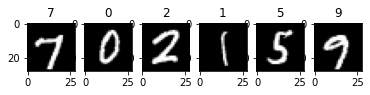

In [3]:
input_folder_path = "input/data/MNIST/"

#The CSV contains a flat file of images, 
#i.e. each 28*28 image is flattened into a row of 784 colums 
#(1 column represents a pixel value)
#For CNN, we would need to reshape this to our desired shape

train_df = pd.read_csv(input_folder_path+"train.csv")

#First column is the target/label
train_labels = train_df['label'].values

#Pixels values start from the 2nd column
train_images = (train_df.iloc[:,1:].values).astype('float32')

#Training and Validation Split
train_images, val_images, train_labels, val_labels = train_test_split(
train_images, train_labels, random_state=2020, test_size=0.2)

#Here we reshape the flat row into [#images,#Channels,#Width,#Height]
#Given this a simple grayscale image, we will have just 1 channel
train_images = train_images.reshape(train_images.shape[0],1,28, 28)
val_images = val_images.reshape(val_images.shape[0],1,28, 28)

#Also, let's plot few samples
for i in range(0, 6):
    plt.subplot(160 + (i+1))
    plt.imshow(train_images[i].reshape(28,28), cmap=plt.get_cmap('gray'))
    plt.title(train_labels[i])

## **Normalize data and prepare train/val datasets**

In [4]:
#Covert Train Images from pandas/numpy to tensor and normalize the values
train_images_tensor = torch.tensor(train_images)/255.0
train_images_tensor = train_images_tensor.view(-1,1,28,28)
train_labels_tensor = torch.tensor(train_labels)

#Create a train TensorDataset
train_tensor = TensorDataset(train_images_tensor, train_labels_tensor)

#Covert Validation Images from pandas/numpy to tensor and normalize the values
val_images_tensor = torch.tensor(val_images)/255.0
val_images_tensor = val_images_tensor.view(-1,1,28,28)
val_labels_tensor = torch.tensor(val_labels)

#Create a Validation TensorDataset
val_tensor = TensorDataset(val_images_tensor, val_labels_tensor)

print("Train Labels Shape:",train_labels_tensor.shape)
print("Train Images Shape:",train_images_tensor.shape)
print("Validation Labels Shape:",val_labels_tensor.shape)
print("Validation Images Shape:",val_images_tensor.shape)

#Load Train and Validation TensorDatasets into the data generator for Training 
train_loader = DataLoader(train_tensor, batch_size=64
, num_workers=2, shuffle=True)
val_loader = DataLoader(val_tensor, batch_size=64, num_workers=2, shuffle=True)

Train Labels Shape: torch.Size([33600])
Train Images Shape: torch.Size([33600, 1, 28, 28])
Validation Labels Shape: torch.Size([8400])
Validation Images Shape: torch.Size([8400, 1, 28, 28])


## **Define Convolutional Neural Network, function to train and predict**

In [5]:
#Define conv-net
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        #First unit of convolution
        self.conv_unit_1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        #Second unit of convolution        
        self.conv_unit_2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        #Fully connected layers
        self.fc1 = nn.Linear(7*7*32, 128)       
        self.fc2 = nn.Linear(128, 10)        
    
    #Connect the units
    def forward(self, x):       
        out = self.conv_unit_1(x)
        out = self.conv_unit_2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)        
        out = F.log_softmax(out,dim=1)                                
        return out

#Define Functions for Model Evaluation and generating Predictions    
def make_predictions(data_loader):
    #Explcitly set the model to eval mode
    model.eval()
    test_preds = torch.LongTensor()
    actual = torch.LongTensor()
    
    for data, target in data_loader:
        
        if torch.cuda.is_available():
            data = data.cuda()
        output = model(data)

        #Predict output/Take the index of the output with max value
        preds = output.cpu().data.max(1, keepdim=True)[1]

        #Combine tensors from each batch
        test_preds = torch.cat((test_preds, preds), dim=0)
        actual  = torch.cat((actual,target),dim=0)
        
    return actual,test_preds

#Evalute model
def evaluate(data_loader):
    model.eval()
    loss = 0
    correct = 0
    
    for data, target in data_loader:        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        output = model(data)
        loss += F.cross_entropy(output, target, size_average=False).data.item()
        predicted = output.data.max(1, keepdim=True)[1]   
        correct += (target.reshape(-1,1) == predicted.reshape(-1,1)).float().sum()        
        
    loss /= len(data_loader.dataset)
        
    print('\nAverage Val Loss: {:.4f}, Val Accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))  

## **Create model instance, define Loss and optimizer**

In [6]:
#Create Model  instance
model = ConvNet(10).to(device)

#Define Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)    
print(model)

ConvNet(
  (conv_unit_1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_unit_2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


## **Model training**

In [7]:
num_epochs = 5

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()        
        
    #After each epoch print Train loss and validation loss + accuracy
    print ('Epoch [{}/{}], Loss: {:.4f}' .format(epoch+1, num_epochs, loss.item()))
    evaluate(val_loader)

Epoch [1/5], Loss: 0.0940


/opt/conda/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Average Val Loss: 0.0792, Val Accuracy: 8165.0/8400 (97.202%)

Epoch [2/5], Loss: 0.0349

Average Val Loss: 0.0518, Val Accuracy: 8265.0/8400 (98.393%)

Epoch [3/5], Loss: 0.0540

Average Val Loss: 0.0515, Val Accuracy: 8262.0/8400 (98.357%)

Epoch [4/5], Loss: 0.0047

Average Val Loss: 0.0562, Val Accuracy: 8254.0/8400 (98.262%)

Epoch [5/5], Loss: 0.0596

Average Val Loss: 0.0568, Val Accuracy: 8271.0/8400 (98.464%)



## **Make predictions**

In [9]:
#Make Predictions on Validation Dataset

actual, predicted = make_predictions(val_loader)
actual,predicted = np.array(actual).reshape(-1,1),np.array(predicted).reshape(-1,1)

print("Validation Accuracy-",round(accuracy_score(actual,predicted),4)*100)
print("\n Confusion Matrix\n",confusion_matrix(actual,predicted))

Validation Accuracy- 98.46000000000001

 Confusion Matrix
 [[810   0   2   1   0   0   2   0   1   1]
 [  1 925   2   1   0   0   0   2   2   1]
 [  0   0 830   2   1   0   0   0   0   0]
 [  0   1   7 858   0   2   0   1   0   2]
 [  1   0   0   0 851   0   0   0   1   2]
 [  0   0   2   6   0 724   3   0   2   0]
 [  1   0   1   1   0   0 798   0   1   0]
 [  0   1   7   0   4   0   0 875   2   3]
 [  3   4   7   3   3   2   5   0 805   2]
 [  0   0   0   0  20   1   0   7   2 795]]
